# Instanciação de Parâmetros

In [35]:
import pyomo as pyo

GENERATE_NEW_SCENARIOS = True

# Solver
solver_name = 'highs'

# Número de meses
T=60

S = 500

# Parâmetros
a = 60  # Constante da demanda
b = 1/2000    # Elasticidade da demanda
variable_cost_percentage = 0.35  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
variable_expenses_percentage = 0.03  # Percentual de custos variáveis
taxes_percentage = 0.07  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
CF = 112_500    # Custo fixo mensal (salários, aluguel, etc)
DF = 247_500    # Despesa fixa mensal
theta_AR = 35/30 # 35 dias de recebimento
theta_I = 30/30 # 30 dias de estoque
theta_AP = 30/30 # 30 dias de pagamento

# Intervalos de preço e quantidade
P_min = 3 # 3 reais por lata
P_max = 3
Q_min = 250_000 # 250.000 latas
inital_sales = 250_000 # Vendas iniciais
Q_max = 1_000_000

# Variação inicial da NCG (exemplo)
initial_NCG = 875_000 + 262_500 - 262_500 # CR + Estoque Inicial - CP
initial_inventory = 262_500 # 

# Meses usados no cálculo do FCO futuro
months_future_FCO = 12

# Taxa de Incremento do Lucro
profit_increment_rate = 0.8 #0.7
growth_rate = 1.019446 # 1.26 a.a

# Value at risk
alpha_var = 0.05
epsilon_var = 10000  # Valor inicial, será atualizado no loop

# Taxa de Desconto
GAMMA = 0.01

import matplotlib.pyplot as plt

plt.rcParams['figure.titlesize'] = 16   # Tamanho do título geral da figura
plt.rcParams['axes.titlesize'] = 16     # Tamanho do título dos eixos
plt.rcParams['axes.labelsize'] = 14     # Tamanho dos rótulos (labels) de eixos x e y
plt.rcParams['legend.fontsize'] = 12    # Tamanho da fonte na legenda
plt.rcParams['xtick.labelsize'] = 12    # Tamanho dos rótulos no eixo x
plt.rcParams['ytick.labelsize'] = 12    # Tamanho dos rótulos no eixo y
plt.style.use('default')

# Modelo Determinístico

In [15]:
from pyomo.environ import *

# Cria um modelo concreto
naive_model = model = ConcreteModel()

# Períodos
T=60

# Variáveis de decisão
model.P = Param(initialize=P_min)
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos

initialize_variable_costs=[variable_cost_percentage*1.015**t for t in range(0, T)]

model.variable_cost_percentage = Param(range(1, T+1), initialize=lambda model, t: initialize_variable_costs[t-1], mutable=True)
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=Q_min)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, t):
    # return 0
    return revenue_rule(model, t) * model.theta_AR

def I_rule(model, t):
    # return 0
    return (model.variable_cost_percentage[t] * revenue_rule(model, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, t):
    i_t_minus_1 = I_rule(model, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, t) + model.variable_cost_percentage[t] * revenue_rule(model, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    else:
        # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) 
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(revenue_rule(model, t_period) -\
        model.variable_cost_percentage[t_period] * revenue_rule(model, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, t_period) - \
        model.taxes_percentage * revenue_rule(model, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, t):
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t)) >= 0

# model.fco = Constraint(range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, t) <= 10e10
    
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, t-1) -\
        model.variable_cost_percentage[t-1] * revenue_rule(model, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, t-1) - \
        model.taxes_percentage * revenue_rule(model, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, T+1), rule=profit_rule)

def non_regression_rule(model, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, T+1), rule=non_regression_rule)

# Componentes da NCG
model.AR = Expression(range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory(solver_name)
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
for t in range(1, T+1):
    print(f'Mês {t}: Preço = {model.P.value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
Mês 1: Preço = 3, Quantidade = 250000.0
Mês 2: Preço = 3, Quantidade = 254861.50000000003
Mês 3: Preço = 3, Quantidade = 259817.53672900004
Mês 4: Preço = 3, Quantidade = 264869.9485482322
Mês 5: Preço = 3, Quantidade = 270020.6095677012
Mês 6: Preço = 3, Quantidade = 275271.4303413547
Mês 7: Preço = 3, Quantidade = 280624.35857577267
Mês 8: Preço = 3, Quantidade = 286081.3798526372
Mês 9: Preço = 3, Quantidade = 291644.5183652516
Mês 10: Preço = 3, Quantidade = 297315.8376693823
Mês 11: Preço = 3, Quantidade = 303097.44144870114
Mês 12: Preço = 3, Quantidade = 308991.4742951126
Mês 13: Preço = 3, Quantidade = 315000.1225042554
Mês 14: Preço = 3, Quantidade = 321125.61488647317
Mês 15: Preço = 3, Quantidade = 327370.22359355557
Mês 16: Preço = 3, Quantidade = 333736.2649615559
Mês 17: Preço = 3, Quantidade = 340226.1003699983
Mês 18: Preço = 3, Quantidade = 346842.1371177933
Mês 19: Preço = 3, Qu

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [16]:
from pyomo.environ import value


def fco_period(model, t):
    return value(model.P * model.Q[t] - model.variable_cost_percentage[t] * model.P * model.Q[t] - model.variable_expenses_percentage * model.P * model.Q[t] - model.taxes_percentage * model.P * model.Q[t] - model.fix_costs - model.fix_expenses - model.NCG[t])

def revenue_period(model, t):
    return value(model.P * model.Q[t])

def profit_period(model, t):
    return value(model.P * model.Q[t] - model.variable_cost_percentage[t] * model.P * model.Q[t] - model.variable_expenses_percentage * model.P * model.Q[t] - model.taxes_percentage * model.P * model.Q[t] - model.fix_costs - model.fix_expenses)

In [17]:
# Verificar se o modelo foi solucionado com sucesso
if result.solver.termination_condition == TerminationCondition.optimal:
    for t in range(1, T+1):
        # Calcula e exibe as componentes diretamente sem usar as expressões model.AR, model.I, model.AP, model.NCG
        AR_value = AR_rule(model, t)()
        I_value = I_rule(model, t)()
        AP_value = AP_rule(model, t)()
        NCG_value = NCG_rule(model, t)()
        revenue_value = revenue_rule(model, t)()

        print(f'Mês {t}: Preço = {model.P.value}, Quantidade = {model.Q[t].value}')
        print(f'  AR = {AR_value}, Estoque (I) = {I_value}, AP = {AP_value}, NCG = {NCG_value}')
        print(f'  NCG = AR - I - AP = {AR_value} - {I_value} - {AP_value} = {NCG_value}')
        # agora o lucro
        # print(f'  Lucro = {revenue_value - model.variable_cost_percentage * revenue_value - model.variable_expenses_percentage * revenue_value - model.taxes_percentage * revenue_value - model.fix_costs - model.fix_expenses}')
else:
    print("O modelo não encontrou uma solução ótima.")

Mês 1: Preço = 3, Quantidade = 250000.0
  AR = 875000.0, Estoque (I) = 262499.99999999994, AP = 262499.9999999999, NCG = 1.1641532182693481e-10
  NCG = AR - I - AP = 875000.0 - 262499.99999999994 - 262499.9999999999 = 1.1641532182693481e-10
Mês 2: Preço = 3, Quantidade = 254861.50000000003
  AR = 892015.2500000001, Estoque (I) = 271618.643625, AP = 280737.2872500001, NCG = 7896.606374999799
  NCG = AR - I - AP = 892015.2500000001 - 271618.643625 - 280737.2872500001 = 7896.606374999799
Mês 3: Preço = 3, Quantidade = 259817.53672900004
  AR = 909361.3785515002, Estoque (I) = 281054.0478654657, AP = 290489.45210593136, NCG = 17029.36793603457
  NCG = AR - I - AP = 909361.3785515002 - 281054.0478654657 - 290489.45210593136 = 17029.36793603457
Mês 4: Preço = 3, Quantidade = 264869.9485482322
  AR = 927044.8199188127, Estoque (I) = 290817.2162534614, AP = 300580.38464145706, NCG = 17355.677219782432
  NCG = AR - I - AP = 927044.8199188127 - 290817.2162534614 - 300580.38464145706 = 17355.6772

## Gráficos de Comportamento da Solução

### Quantidade de Vendas por Período

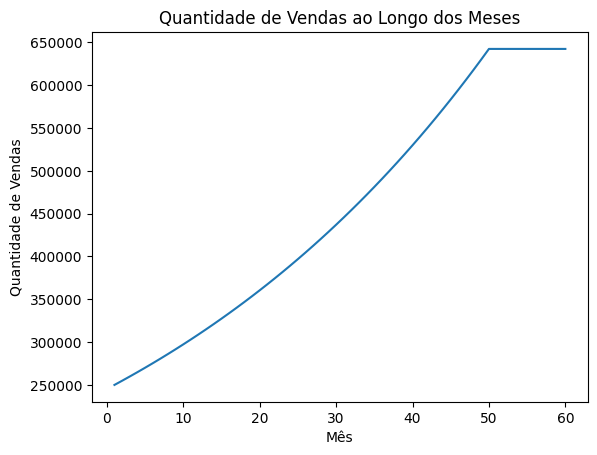

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

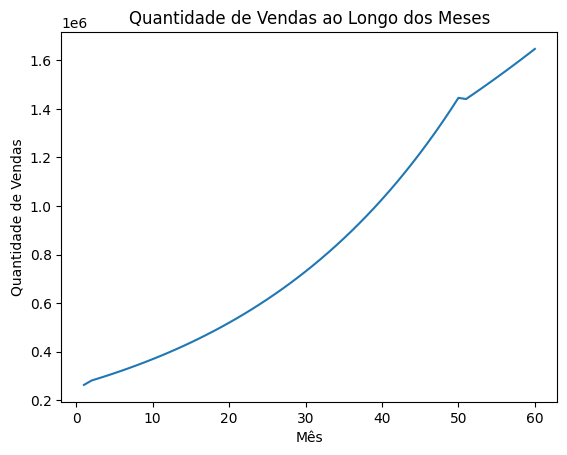

In [19]:
import matplotlib.pyplot as plt

# plt.plot(range(1, 3), [value(AR_rule(model, t)) for t in range(1, 3)], label='AR')

plt.plot(range(1, T+1), [value(AP_rule(model, t)) for t in range(1, T+1)], label='AP')

# plt.plot(range(1, 3), [value(I_rule(model, t)) for t in range(1, 3)], label='I')

plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

# plt.plot(range(1, 3), [value(AP_rule(model, t)) for t in range(1, 3)])
# plt.xlabel('Mês')
# plt.ylabel('Quantidade de Vendas')
# plt.title('Quantidade de Vendas ao Longo dos Meses')
# plt.show()

### Receita por Período

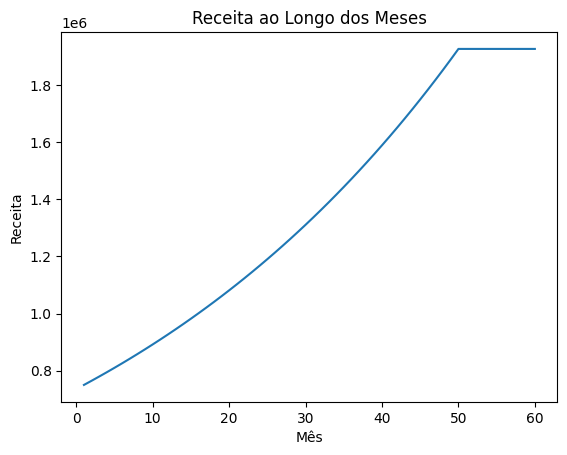

In [20]:
plt.plot(range(1, T+1), [revenue_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses')
plt.show()

### Lucro por Período

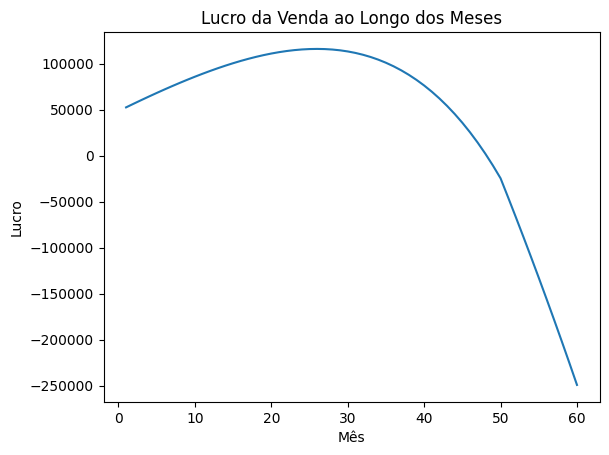

In [21]:
plt.plot(range(1, T+1), [profit_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro da Venda ao Longo dos Meses')
plt.show()

### Fluxo de Caixa Operacional por Período

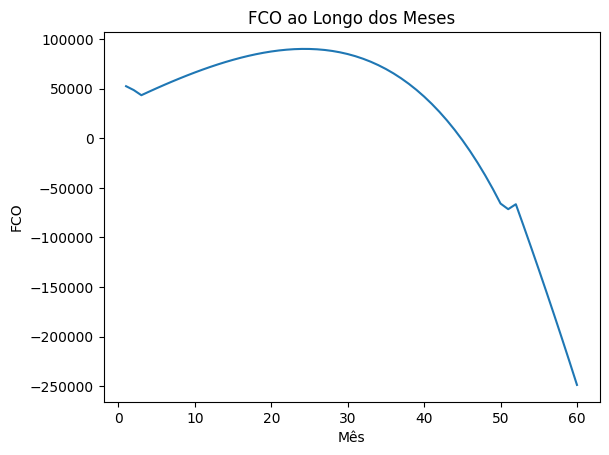

In [22]:
plt.plot(range(1, T+1), [fco_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('FCO')
plt.title('FCO ao Longo dos Meses')
plt.show()

# Descobrindo possíveis variações no valor de custos variáveis com base na variação do dólar

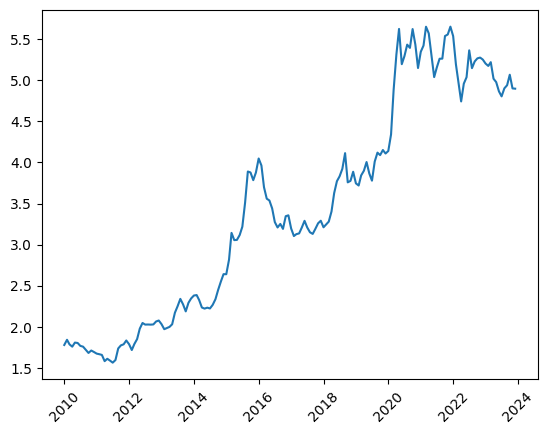

In [23]:
from currency_converter import CurrencyConverter
from datetime import datetime
from numpy import mean
import calendar
import matplotlib.pyplot as plt

c = CurrencyConverter(fallback_on_missing_rate=True)

# Pega a média do dólar mensal desde 2010
dolar_mean = []
for i in range(2010, 2024):
    for j in range(1, 13):
        _, num_days = calendar.monthrange(i, j)
        dolar_mean.append(mean([c.convert(1, 'USD', 'BRL', date=datetime(i, j, k)) for k in range(1, num_days+1)]))

# Plota o gráfico utilizando datas no eixo x
plt.plot([datetime(i, j, 1) for i in range(2010, 2024) for j in range(1, 13)], dolar_mean)
plt.xticks(rotation=45)
plt.show()


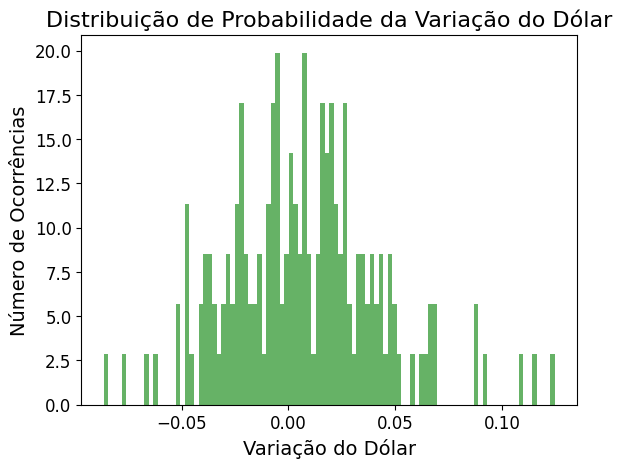

In [24]:
# Distribuição de probabilidades da variação do dólar baseado na série temporal dolar_mean
from scipy.stats import norm
import numpy as np

dolar_mean_variation = np.diff(dolar_mean)

#  Agora uma lista que pega o calor do dolar e soma com a variação
dolar_mean_variation = [(dolar_mean[i] + dolar_mean_variation[i])/dolar_mean[i] - 1 for i in range(len(dolar_mean_variation))]

# plot the histogram
plt.hist(dolar_mean_variation, bins=100, density=True, alpha=0.6, color='g')
plt.xlabel('Variação do Dólar', fontsize=14)
plt.ylabel('Número de Ocorrências', fontsize=14)
plt.title('Distribuição de Probabilidade da Variação do Dólar', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


In [25]:
# Extrair os parâmetros dos dados
target_mean = np.mean(dolar_mean_variation)
target_variance = np.var(dolar_mean_variation)
target_skewness = np.mean((dolar_mean_variation - target_mean)**3) / target_variance**(3/2)
target_kurtosis = np.mean((dolar_mean_variation - target_mean)**4) / target_variance**2


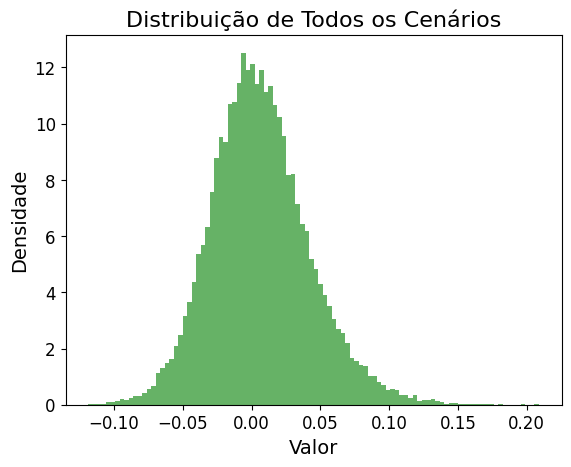

In [26]:
# Baseado no https://bjerring.github.io/equity/2019/12/12/Scenario-Generation-and-Moment-Matching.html

import numpy as np
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pickle

def moment_matching_func(x, *args):
    """Função de ajuste de momentos que minimiza o erro entre os cenários gerados e os momentos-alvo."""
    para_match = args[0]
    exp_mu, exp_sds, exp_skew, exp_kur, exp_cov_m = para_match

    # Calcula a matriz de correlação a partir da covariância
    std_ = np.sqrt(np.diag(exp_cov_m)) if exp_cov_m.ndim > 1 else np.sqrt(exp_cov_m)
    exp_cor_m = exp_cov_m / np.outer(std_, std_) if exp_cov_m.ndim > 1 else 1.0

    # Reshape dos cenários gerados
    xx = np.reshape(x, (-1, len(exp_mu)))

    # Calcula os momentos dos cenários
    m1 = np.mean(xx, axis=0)
    m2 = np.std(xx, axis=0)
    m3 = [skew(xx[:, i]) for i in range(len(exp_mu))]
    m4 = [kurtosis(xx[:, i]) for i in range(len(exp_mu))]

    # Calcula o erro como a soma dos quadrados das diferenças
    epsilon = (np.sum((m1 - exp_mu)**2) +
               np.sum((m2 - exp_sds)**2) +
               np.sum((m3 - exp_skew)**2) +
               np.sum((m4 - exp_kur)**2) +
               np.sum((np.corrcoef(xx, rowvar=False) - exp_cor_m)**2))

    return epsilon

def generate_scenarios_with_moment_matching(mu, sigma, skewness, kurtosis, covariance, size=10000):
    """
    Gera cenários ajustando os momentos estatísticos fornecidos.
    """
    # Define os momentos-alvo
    para_match = (mu, sigma, skewness, kurtosis, covariance)

    # Verifica se a covariância é escalar (para uma variável)
    if covariance.ndim == 1:
        covariance = np.array([[covariance[0]]])  # Torna a matriz 2D para compatibilidade

    # Inicializa os cenários com uma distribuição normal multivariada
    x_ini = np.random.multivariate_normal(mu, covariance, size).ravel()

    # Minimiza o erro entre os momentos gerados e os momentos-alvo
    res = minimize(moment_matching_func, x_ini, method='CG', args=(para_match,))

    # Retorna os cenários ajustados
    scenarios = np.reshape(res.x, (-1, len(mu)))

    return scenarios

def extract_moments_and_covariance(data):
    """
    Extrai os momentos estatísticos e a matriz de covariância dos dados fornecidos.
    """
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    skewness = skew(data, axis=0)
    kurtosis_vals = kurtosis(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    
    # Se for uma variável, ajuste a covariância para ser um array
    if covariance.ndim == 0:
        covariance = np.array([[covariance]])
    
    return mu, sigma, skewness, kurtosis_vals, covariance

# Parâmetros dos cenários
scenarios = 500  # Número de cenários
initial_variable_costs = 0.35
dolar_affect_parameter = 0.5
if GENERATE_NEW_SCENARIOS:

    # Substitua pelo histórico da variação do dólar
    historical_data = np.array(dolar_mean_variation).reshape(-1, 1)
    mu, sigma, skewness, kurtosis_vals, covariance = extract_moments_and_covariance(historical_data)

    # Gera os cenários
    scenarios_data = []

        # Gerando valor ajustado aos momentos
    data_point = generate_scenarios_with_moment_matching(
        mu=mu, 
        sigma=sigma, 
        skewness=skewness, 
        kurtosis=kurtosis_vals, 
        covariance=covariance, 
        size=(T-1)*scenarios # Subtraio 1 pois o primeiro mês é o valor percentual inicial
    )
        
    scenarios_data = data_point

    all_data = scenarios_data.copy()

    pickle.dump(scenarios_data, open('all_data.pkl', 'wb'))

else:
    all_data = pickle.load(open('all_data.pkl', 'rb'))

# Visualiza os dados de todos os cenários
plt.hist(all_data, bins=100, density=True, alpha=0.6, color='g')
plt.title('Distribuição de Todos os Cenários', fontsize=16)
plt.xlabel('Valor', fontsize=14)
plt.ylabel('Densidade', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [27]:
# scenarios_alt = np.zeros((scenarios, T))

if GENERATE_NEW_SCENARIOS:
    scenarios_data = all_data.reshape(scenarios, (T-1)).tolist()

    values = []
    for i in range(scenarios):
        values_list = [initial_variable_costs]
        for t in range(1, T):
            values_list.append(values_list[t-1] + scenarios_data[i][t-1] * dolar_affect_parameter)
        values.append(values_list)

    scenarios_data = values

    pickle.dump(scenarios_data, open('scenarios_data.pkl', 'wb'))

else:
    scenarios_data = pickle.load(open('scenarios_data.pkl', 'rb'))



# Modelo Múltiplo

In [28]:
from pyomo.environ import *

# Cria um modelo concreto
model = ConcreteModel()

# Períodos
T=60

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=P_min)
model.Q = Var(range(1, scenarios+1), range(1, T+1), bounds=(Q_min, Q_max*2), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1])

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
for i in range(1, scenarios+1):
    model.Q[i, 1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[i, t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG


# Função objetivo

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
# BREAKPOINT
def growth_rule(model, i, t):
    return model.Q[i, t] <= model.Q[i, t-1] * growth_rate if t > 1 else model.Q[i, t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def non_regression_rule(model, i, t):
    return model.Q[i, t] >= model.Q[i, t-1] if t > 1 else model.Q[i, t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory(solver_name)
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms


## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [29]:
from pyomo.environ import value


def fco_period_multiple(model, i, t):
    return value(model.P * model.Q[i, t] - model.variable_cost_percentage[i, t] * model.P * model.Q[i, t] - model.variable_expenses_percentage * model.P * model.Q[i, t] - model.taxes_percentage * model.P * model.Q[i, t] - model.fix_costs - model.fix_expenses - model.NCG[i, t])

def revenue_period_multiple(model, i, t):
    return value(model.P * model.Q[i, t])

def profit_period_multiple(model, i, t):
    return value(model.P * model.Q[i, t] - model.variable_cost_percentage[i, t] * model.P * model.Q[i, t] - model.variable_expenses_percentage * model.P * model.Q[i, t] - model.taxes_percentage * model.P * model.Q[i, t] - model.fix_costs - model.fix_expenses)

## Gráficos de Comportamento da Solução

### Quantidade de Vendas por Período

Text(0.5, 1.0, 'Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

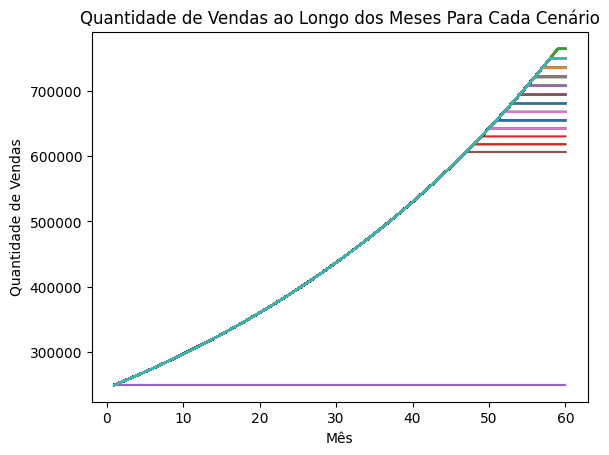

In [30]:
# plot de preço e quantidade para cada cenário
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [model.Q[i, t].value for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

### Receita por Período

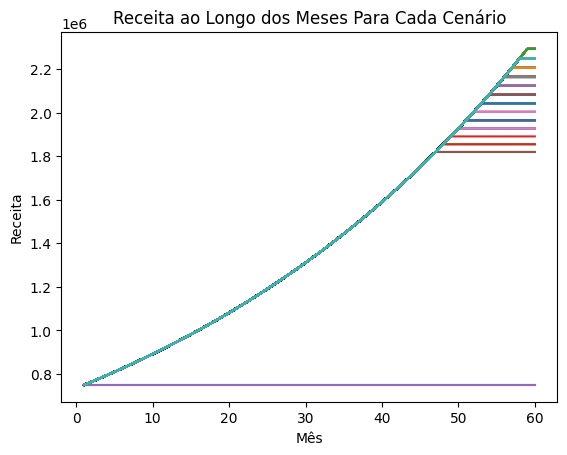

In [31]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

### Lucro por Período

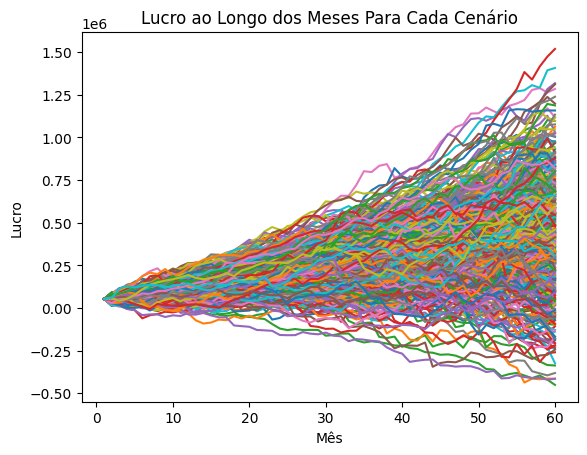

In [32]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

### Fluxo de Caixa Operacional por Período

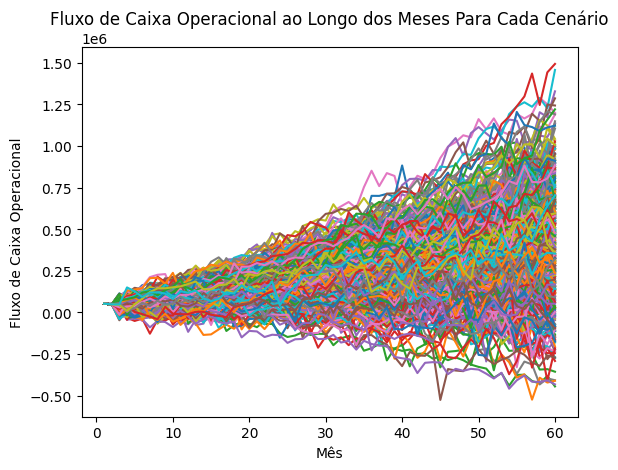

In [33]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

# Modelo Estocástico Mono-objetivo | FCO Último Ano

In [36]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T=60

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=P_min)
model.Q = Var(range(1, T+1), bounds=(Q_min, 2*Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

def other_objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def fco_rule_exp(model, i):
    t_final = T
    return -sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

def non_regression_rule(model, i, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory(solver_name)
# solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

TypeError: Cannot create a Set from data that does not support __contains__.  Expected set-like object supporting collections.abc.Collection interface, but received 'int'.

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [706]:
from pyomo.environ import value


def fco_period(model, i, t):
    return value(3 * model.Q[t] - model.variable_cost_percentage[i, t] * 3 * model.Q[t] - model.variable_expenses_percentage * 3 * model.Q[t] - model.taxes_percentage * 3 * model.Q[t] - model.fix_costs - model.fix_expenses - model.NCG[i, t])

def revenue_period(model, i, t):
    return value(3 * model.Q[t])

def profit_period(model, i, t):
    return value(3 * model.Q[t] - model.variable_cost_percentage[i, t] * 3 * model.Q[t] - model.variable_expenses_percentage * 3 * model.Q[t] - model.taxes_percentage * 3 * model.Q[t] - model.fix_costs - model.fix_expenses)

## Quantidade de Vendas por Período

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Quantidade de Vendas', fontsize=14)
plt.title('Quantidade de Vendas ao Longo dos Meses', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print([model.Q[t].value for t in range(1, T+1)])

## Receita por Período

In [ ]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

In [ ]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

In [ ]:


for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

# aumentar tamanho do titulo e dos eixos

plt.xlabel('Mês', fontsize=14)
plt.ylabel('Fluxo de Caixa Operacional', fontsize=14)
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Distribuição de FCO

In [ ]:
fco_values = [-value(model.FCO[i]) for i in S]

# descbrir var e cvar por cálculo, não utilizar model.VaR
var_value = sorted(fco_values)[int(len(fco_values) * 0.05)]
cvar_value = sum([fco for fco in fco_values if fco < var_value]) / int(len(fco_values) * 0.05)
alpha=0.95

import matplotlib.pyplot as plt
import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label=f'Distribuição Empírica do FCO (max={round(max(fco_values), 2)})', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({1-alpha:.2f})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO', fontsize=20)
plt.xlabel('Fluxo de Caixa Operacional (FCO)', fontsize=18)
plt.ylabel('Probabilidade Acumulada', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# Exibir
plt.show()

## Valores das 2 funções objetivo

In [ ]:
print(f'Valor da Função Objetivo FCO: {model.objective()}')
print(f'Valor da Função NPV por GUROBI: {value(other_objective_rule(model))}')
print(f'Valor da Função NPV por Cálculo : {value(sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + GAMMA)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, T+1)))}')

# Modelo Estocástico Mono-objetivo | Valor Presente Líquido

In [ ]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T=60

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=P_min)
model.Q = Var(range(1, T+1), bounds=(Q_min, 2*Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def other_objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def fco_rule_exp(model, i):
    t_final = T
    return -sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

def non_regression_rule(model, i, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory(solver_name)
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

## Quantidade de Vendas por Período

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Quantidade de Vendas', fontsize=14)
plt.title('Quantidade de Vendas ao Longo dos Meses', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

print([model.Q[t].value for t in range(1, T+1)])

## Receita por Período

In [ ]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

In [ ]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

In [ ]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês', fontsize=14)
plt.ylabel('Fluxo de Caixa Operacional', fontsize=14)
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## Distribuição de FCO

In [ ]:
fco_values = [-value(model.FCO[i]) for i in S]

# descbrir var e cvar por cálculo, não utilizar model.VaR
var_value = sorted(fco_values)[int(len(fco_values) * 0.05)]
cvar_value = sum([fco for fco in fco_values if fco < var_value]) / int(len(fco_values) * 0.05)
alpha=0.95

import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label=f'Distribuição Empírica do FCO (max={round(max(fco_values), 2)})', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({1-alpha:.2f})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO', fontsize=16)
plt.xlabel('Fluxo de Caixa Operacional (FCO)', fontsize=14)
plt.ylabel('Probabilidade Acumulada', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Exibir
plt.show()

In [ ]:
var_value

## Valores das 2 funções objetivo

In [ ]:
print(f'Valor da Função Objetivo NPV: {model.objective()}')
print(f'Valor da Função FCO por GUROBI: {value(other_objective_rule(model))}')
print(f'Valor da Função FCO por Cálculo : {sum(sum(fco_period(model, i, t) for i in range(1, scenarios+1))/scenarios for t in range(1, T+1))}')

# Modelo Estocástico Mono-objetivo | CVaR

In [ ]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T=60
S = range(1, 500+1)  # Cenários

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=3)
model.Q = Var(range(1, T+1), bounds=(Q_min, 2*Q_max), within=NonNegativeReals)

# Variáveis para CVaR
model.VarDev = Var(S, within=NonNegativeReals)  # Desvio por cenário
model.VaR = Var(within=Reals)        # Valor em Risco (VaR)
model.CVaR = Var(within=Reals)       # CVaR

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def other_objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def non_regression_rule(model, i, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Restrições para o CVaR
# Restrição para desvio por cenário
def fco_rule_exp(model, i):
    t_final = T
    return -sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

def vardev_rule(model, i):
    return model.FCO[i] - model.VaR <= model.VarDev[i]

model.vardev_constraint = Constraint(S, rule=vardev_rule)

# Restrição para definição do CVaR
def cvar_rule(model):
    alpha=0.05
    return model.VaR + (1 / (len(S) * alpha)) * sum(model.VarDev[i] for i in S) == model.CVaR

model.cvar_constraint = Constraint(rule=cvar_rule)

# minimizar o CVaR
model.objective = Objective(expr=model.CVaR, sense=minimize)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory(solver_name)
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

## Quantidade de Vendas por Período

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês', fontsize=14)
plt.ylabel('Quantidade de Vendas', fontsize=14)
plt.title('Quantidade de Vendas ao Longo dos Meses', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print([model.Q[t].value for t in range(1, T+1)])

## Receita por Período

In [ ]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

In [ ]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

In [ ]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês', fontsize=14)
plt.ylabel('Fluxo de Caixa Operacional', fontsize=14)
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Distribuição de FCO

In [ ]:
fco_values = [-value(model.FCO[i]) for i in S]

# descbrir var e cvar por cálculo, não utilizar model.VaR
var_value = sorted(fco_values)[int(len(fco_values) * 0.05)]
cvar_value = sum([fco for fco in fco_values if fco < var_value]) / int(len(fco_values) * 0.05)
alpha=0.95

import matplotlib.pyplot as plt
import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label=f'Distribuição Empírica do FCO (max={round(max(fco_values), 2)})', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({1-alpha:.2f})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO', fontsize=20)
plt.xlabel('Fluxo de Caixa Operacional (FCO)', fontsize=18)
plt.ylabel('Probabilidade Acumulada', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

# Exibir
plt.show()

## Valores das 2 funções objetivo

In [ ]:
print(f'Valor da Função Objetivo NPV: {model.objective()}')
print(f'Valor da Função FCO por GUROBI: {value(other_objective_rule(model))}')
print(f'Valor da Função FCO por Cálculo : {sum(sum(fco_period(model, i, t) for i in range(1, scenarios+1))/scenarios for t in range(1, T+1))}')

# Criação da Fronteira Pareto - Problema Multi-objetivo

## Teste com CVaR

In [695]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T=60
S = range(1, 500+1)  # Cenários

# Variáveis de decisão, agora são T * scenarios
model.P = Param(initialize=3)
model.Q = Var(range(1, T+1), bounds=(Q_min, 2*Q_max), within=NonNegativeReals)

# Variáveis para CVaR
model.VarDev = Var(S, within=NonNegativeReals)  # Desvio por cenário
model.VaR = Var(within=Reals)        # Valor em Risco (VaR)
model.CVaR = Var(within=Reals)       # CVaR

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=inital_sales)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    gamma = GAMMA
    t_final = T
    # soma FCO_i / (1 + gamma)^t
    return sum(sum((revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period)) / (1 + gamma)**t_period for i in range(1, scenarios+1))/scenarios for t_period in range(1, t_final+1))

def other_objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

# model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * growth_rate if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

# model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

def non_regression_rule(model, i, t):
    return model.Q[t] >= model.Q[t-1] if t > 1 else model.Q[t] >= model.initial_quantity

model.non_regression = Constraint(range(1, scenarios+1), range(1, T+1), rule=non_regression_rule)

# Restrições para o CVaR
# Restrição para desvio por cenário
def fco_rule_exp(model, i):
    t_final = T
    return -sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

def vardev_rule(model, i):
    return model.FCO[i] - model.VaR <= model.VarDev[i]

model.vardev_constraint = Constraint(S, rule=vardev_rule)

# Restrição para definição do CVaR
def cvar_rule(model):
    alpha=0.05
    return model.VaR + (1 / (len(S) * alpha)) * sum(model.VarDev[i] for i in S) == model.CVaR

model.cvar_constraint = Constraint(rule=cvar_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

In [ ]:
# OBJETIVO

solutions = []
pop_x = []

spaced = 100

for i, beta in enumerate(np.linspace(0.001, 1, spaced)):
    print(f'Iteration {i+1}/{spaced}')
    #  remove objective
    if i > 0:
        model.del_component(model.objective)
    model.objective = Objective(expr=-model.CVaR * beta + (1-beta)*objective_rule(model), sense=maximize)
    solver = SolverFactory(solver_name)
    # solver.options['NonConvex'] = 2
    result = solver.solve(model, tee=True, warmstart=False)
    # Beta, CVaR, FCO, NPV, Quantidade Final, Quantidades Mensais, FCOs, FCOs Mensais

    for j in range(1, scenarios+1):
            fcos_scenarios = [fco_period(model, j, t) for t in range(1, T+1)]

    solutions.append((
        beta, 
        value(model.CVaR), 
        value(objective_rule(model)), 
        value(alternative_objective_net_present_value_rule(model)),
        value(model.Q[T]),
        [value(model.Q[t]) for t in range(1, T+1)],
        [value(model.FCO[i]) for i in S],
        fcos_scenarios
    ))

    

    x_sol = []

    # 1) P_{i,t}
    #    model.P[i+1, t+1] no Pyomo => lembre-se que no Pyomo o i e t começam em 1..
    for i_scenario in range(scenarios):
        for t_period in range(T):
            x_sol.append(value(model.P))

    # 2) Q_t
    for t_period in range(T):
        x_sol.append(value(model.Q[t_period+1]))

    # 3) VarDev_i (se existir)
    for i_scenario in range(scenarios):
        # Se não estiver usando, pode colocar 0.0
        # ou, se estiver, use value(model.VarDev[i_scenario+1])
        x_sol.append(0.0)

    # 4) VaR e CVaR (2 vars extras)
    x_sol.append(value(model.VaR))
    x_sol.append(value(model.CVaR))

    pop_x.append(x_sol)


solutions


## Plotagem da Fronteira Pareto

In [ ]:
import matplotlib.pyplot as plt

def plot_solutions(solutions):
    # Extraindo as variáveis
    betas = [sol[0] for sol in solutions]
    CVAR = [-sol[1] for sol in solutions]
    FCO = [sol[2] for sol in solutions]

    # Cria a figura e o primeiro eixo
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Cor para a primeira série (CVAR)
    color1 = 'tab:blue'
    ax1.set_xlabel('Beta')
    ax1.set_ylabel('CVAR')
    ax1.plot(betas, CVAR, color=color1, label='CVAR')
    ax1.tick_params(axis='y')
    
    # Cria o segundo eixo (compartilhando o mesmo eixo x)
    ax2 = ax1.twinx()

    # Cor para a segunda série (FCO)
    color2 = 'tab:red'
    ax2.set_ylabel('FCO')
    ax2.plot(betas, FCO, color=color2, label='FCO')
    ax2.tick_params(axis='y')

    # Adiciona título e grade
    plt.title('Soluções para diferentes valores de beta')
    plt.grid(True)
    
    # Ajusta layout para evitar sobreposição
    fig.tight_layout()

    # Cria uma legenda combinada
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='center left',         # Posição da legenda (centro-esquerda)
    bbox_to_anchor=(0.0, 0.5)  # Ajuste da âncora do bounding box
)

    # Exibe o gráfico
    plt.show()

# Chamada de exemplo
plot_solutions(solutions)


In [642]:
# solutions_to_plot = [(sol[0], sol[1], sol[2], sol[3], sol[4]) for sol in solutions]

backup_solutions_to_plot = solutions_to_plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pareto(solutions):
    plt.style.use('ggplot')
    figsize = (10, 6)
    marker_size = 100
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Converte as soluções para um array numpy para facilitar a manipulação
    solutions = np.array(solutions)
    
    # Plota os pontos da fronteira de Pareto usando seaborn
    sns.scatterplot(x=[-s for s in solutions[:, 1]], y=solutions[:, 2], color='blue', s=marker_size, alpha=0.6, edgecolor='w', label='Fronteira de Pareto', ax=ax)
    
    # Coloca os eixos como múltiplos de 10^6
    ax.ticklabel_format(axis='x', style='plain')
    ax.ticklabel_format(axis='y', style='plain')
    
    # Melhorias estéticas
    ax.set_xlabel('CVaR', fontsize=14)
    ax.set_ylabel('FCO', fontsize=14)
    ax.set_title('Fronteira de Pareto', fontsize=16)
    ax.legend()
    ax.grid(True)
    
    plt.show()
    
plot_pareto(solutions)

## Filtragem da Fronteira Pareto

In [ ]:
filtered_solutions = []
filtered_pop_x = []

for i, sol in enumerate(solutions):
    if not any(sol[1] == s[1] and sol[2] == s[2] and sol[3] == s[3] and sol[4] == s[4] for s in filtered_solutions):
        filtered_solutions.append(sol)
        filtered_pop_x.append(pop_x[i])

filtered_solutions

# Tomada de Decisão

## Variáveis de Decisão

Para a tomada de decisão, é necessário definir as variáveis de decisão que serão utilizadas para a resolução do problema. As variáveis de decisão são as variáveis que podem ser controladas pelo tomador de decisão e que influenciam o resultado do problema. No caso do problema proposto, as variáveis de decisão são:

- FCO dos últimos 12 Meses
- Valor Presente Líquido
- CVaR
- Quantidade de vendas por período

## Algoritmo de Decisão
Em um primeiro momento, será utilizada a abordagem de definição de Pesos pelo AHP e a execução do método TOPSIS para a tomada de decisão. Posteriormente, a abordagem estendida de Bellman-Zadeh será utilizada para a tomada de decisão.

### Descobrindo os Pesos com o AHP

In [ ]:
import numpy as np
from tabulate import tabulate


m = 344    # número de alternativas
n = 3      # número de critérios

# Definir os critérios do problema
criterios = ["CVaR (C1)", "FCO (C2)", "NPV (C3)", "Quantidade Final (C4)"]

# Matriz de comparação entre os critérios
# Substitua pelos valores do seu problema
comparison_matrix = np.array([
    [1,   3, 4, 4],  # C1 é 3x mais importante que C2, 4 vezes mais que C3 e 4 vezes mais que C4
    [1/3, 1, 2, 2],  # C2 é 3 vezes menos importante que C1, 2 vezes mais que C3 e 2 vezes mais que C4
    [1/4, 1/2, 1, 1],  # C3 é 4 vezes menos importante que C1, 2 vezes menos que C2 e igual a C4
    [1/4, 1/2, 1, 1]   # C4 é 4 vezes menos importante que C1, 2 vezes menos que C2 e igual a C3
], dtype=float)

# Normalizar
column_sums = np.sum(comparison_matrix, axis=0)          # soma de cada coluna
normalized_matrix = comparison_matrix / column_sums      # normaliza cada coluna
pesos = np.mean(normalized_matrix, axis=1)    

pesos_utilizados = pesos

pesos

### Aplicando o Promethee II

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate

# Exemplo de listas para critérios (substitua pelos dados do seu problema)
criterio_1 = [-s[1] for s in filtered_solutions]  # CVaR (vem positivo, mas é negativo)
criterio_2 = [s[2] for s in filtered_solutions]  # FCO
criterio_3 = [s[3] for s in filtered_solutions]  # NPV
criterio_4 = [s[4] for s in filtered_solutions]  # Quantidade Final

# Número de alternativas e critérios
n_alternativas = len(criterio_1)
n_criterios = 4

# Matriz de critérios
criterios = np.array([criterio_1, criterio_2, criterio_3, criterio_4]).T

# Funções de avaliação para os critérios
def G1(x):  # Critério 1: Maximizar (linear)
    # CVaR entre -2655496 e -2452862 - Diferença entre -202634 e +202634
    p = 202634
    return max(0.0, min(1.0, x / p))

def G2(x):  # Critério 2: Maximizar (linear)
    # FCO entre 4468706 e 3872318 - Diferença entre 596388 e -596388
    p = 596388
    return max(0.0, min(1.0, x / p))

def G3(x):  # Critério 3: Maximizar (linear)
    # Custo entre 8653171 e 8317484 - Diferença entre 335687 e -335687
    p = 335687
    return max(0.0, min(1.0, x / p))

def G4(x):  # Critério 4: Maximizar (usual)
    # QOA entre 0 e 1; Simplesmente retornar o valor
    return 1.0 if x > 0.0 else 0.0

# Pesos dos critérios
pesos = pesos_utilizados

# Construção da matriz de preferências parciais
Pj = np.zeros((n_alternativas, n_alternativas, n_criterios))
for i in range(n_alternativas):
    for k in range(n_alternativas):
        for j in range(n_criterios):
            diff = criterios[i, j] - criterios[k, j]
            if j == 0:
                Pj[i, k, j] = G1(diff)
            elif j == 1:
                Pj[i, k, j] = G2(diff)
            elif j == 2:
                Pj[i, k, j] = G3(diff)
            else:
                Pj[i, k, j] = G4(diff)

# Construção da matriz de preferências agregadas
P = np.zeros((n_alternativas, n_alternativas))
for i in range(n_alternativas):
    for k in range(n_alternativas):
        P[i, k] = np.sum(pesos * Pj[i, k, :])

# Exibição da matriz de preferências agregadas
headers = [f"A{i+1}" for i in range(n_alternativas)]
print(tabulate(([headers[i]] + P[i, :].tolist() for i in range(n_alternativas)), headers=headers))

# Fluxos positivos, negativos e finais
phip = np.sum(P, axis=1)  # Fluxo positivo
phim = np.sum(P, axis=0)  # Fluxo negativo
phi = phip - phim         # Fluxo final

# Exibição dos fluxos
print("\nFluxos Positivos:", phip)
print("Fluxos Negativos:", phim)
print("Fluxos Finais:", phi)

# Construção dos grafos de preferências e indiferenças
Pf = phi[:, None] > phi  # Preferência
If = phi[:, None] == phi  # Indiferença

# Grafo de preferência (direcionado)
fig_pref, ax_pref = plt.subplots(figsize=[12, 10])
grafo_pref = nx.DiGraph(Pf)
nx.draw_circular(grafo_pref,
                 ax=ax_pref,
                 arrowsize=20,
                 with_labels=True,
                 labels={i: f"A{i+1}" for i in range(n_alternativas)},
                 node_color='moccasin')
ax_pref.set_title("Preferência", fontsize=30)
plt.show()

# Grafo de indiferença (não-direcionado)
fig_indif, ax_indif = plt.subplots(figsize=[12, 10])
grafo_indif = nx.Graph(If)
nx.draw_circular(grafo_indif,
                 ax=ax_indif,
                 arrowsize=20,
                 with_labels=True,
                 labels={i: f"A{i+1}" for i in range(n_alternativas)},
                 node_color='moccasin')
ax_indif.set_title("Indiferença", fontsize=20)
plt.show()


### Analisando a Solução na Fronteira Pareto

In [ ]:
# plt.style.use('ggplot')
figsize = (10, 6)
marker_size = 100

fig2, ax2 = plt.subplots(figsize=figsize)
scatter2 = ax2.scatter(criterio_1, criterio_2, c='green', s=marker_size, alpha=0.6, edgecolors='w', label='CVaR X FCO')
ax2.set_ylabel("FCO", fontsize=18)
ax2.set_xlabel("CVaR", fontsize=18)
ax2.set_title("Fronteira de Pareto", fontsize=20)
ax2.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax2.grid(True)

# Marcar ponto com [Prioridade, Custo] = [prioridades[19], custos[19]]
ax2.scatter(criterio_1[4], criterio_2[4], c='red', s=marker_size, alpha=0.6, edgecolors='w', label='Solução Ideal')

# Exibir o gráfico
plt.show()

## Gráficos da Solução

In [ ]:
quantity = filtered_solutions[4][5]

plt.plot(range(1, T+1), quantity)
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

In [ ]:
fco_values = [-val for val in filtered_solutions[4][6]]

# descbrir var e cvar por cálculo, não utilizar model.VaR
var_value = sorted(fco_values)[int(len(fco_values) * 0.05)]
cvar_value = sum([fco for fco in fco_values if fco < var_value]) / int(len(fco_values) * 0.05)
alpha=0.95

import matplotlib.pyplot as plt
import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label=f'Distribuição Empírica do FCO (max={round(max(fco_values), 2)})', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({0.05})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO')
plt.xlabel('Fluxo de Caixa Operacional (FCO)')
plt.ylabel('Probabilidade Acumulada')
plt.legend()
plt.grid(True)

# Exibir
plt.show()

## Utilização do Algoritmo de Bellman-Zadeh sem Cenários

In [ ]:
import numpy as np
from tabulate import tabulate

###############################################################################
# 1) Organizar os Dados: gerar a matriz (N, 4) a partir de filtered_solutions
###############################################################################

# Supondo que 'filtered_solutions' já exista no seu código:
# filtered_solutions[i] = (beta, CVaR, FCO, NPV, QFinal, ...)
# Precisamos extrair somente as colunas dos 4 critérios.

N = len(filtered_solutions)  # Número de soluções (linhas)
P = 4                        # Número de critérios (colunas)

# Cria a matriz 'dados' onde cada linha é uma solução e cada coluna um critério.
dados = np.zeros((N, P), dtype=float)

for i in range(N):
    # Critério 1: CVaR (minimizar)
    dados[i, 0] = filtered_solutions[i][1]
    # Critério 2: FCO (maximizar)
    dados[i, 1] = filtered_solutions[i][2]
    # Critério 3: NPV (maximizar)
    dados[i, 2] = filtered_solutions[i][3]
    # Critério 4: QFinal (maximizar)
    dados[i, 3] = filtered_solutions[i][4]

# Nomes dos critérios, para referência
criterios = ["CVaR (min)", "FCO (max)", "NPV (max)", "QFinal (max)"]

# Nome simbólico das soluções. Se quiser indicar o 'beta', por exemplo:
sol_names = [f"Solução {i+1} | beta={filtered_solutions[i][0]:.3f}"
             for i in range(N)]

###############################################################################
# 2) Definir se cada coluna é critério de min ou max
###############################################################################
tipos = ["min", "max", "max", "max"]

###############################################################################
# 3) Calcular valores mínimos e máximos de cada critério
###############################################################################
cmin = np.min(dados, axis=0)  # shape (4,)
cmax = np.max(dados, axis=0)  # shape (4,)

###############################################################################
# 4) Definir expoentes lambda (um para cada critério) caso queira
###############################################################################
lambda_p = np.array([6, 4, 2, 2], dtype=float)

###############################################################################
# 5) Construir a Matriz de Pertinência A (N, P)
#    A[i, j] = grau de pertinência da solução i no critério j
###############################################################################
A = np.zeros((N, P), dtype=float)

for j in range(P):
    # Evitar divisão por zero se cmax[j] == cmin[j]
    denom = cmax[j] - cmin[j] if (cmax[j] != cmin[j]) else 1.0

    for i in range(N):
        x = dados[i, j]

        if tipos[j] == "min":
            # quanto MENOR x, maior a pertinência
            numer = (cmax[j] - x)
        else:
            # quanto MAIOR x, maior a pertinência
            numer = (x - cmin[j])

        # Garante ratio entre [0,1]
        ratio = 0.0
        if denom != 0.0:
            ratio = max(0.0, min(1.0, numer / denom))

        # Aplica o expoente lambda
        A[i, j] = ratio ** lambda_p[j]

###############################################################################
# 6) Exibir a Matriz de Pertinência por Critério, se desejar
###############################################################################
print("\n=== MATRIZ DE PERTINÊNCIA (Bellman-Zadeh) ===\n")
table_lines = []
for i in range(N):
    row = [sol_names[i]] + [f"{A[i, j]:.4f}" for j in range(P)]
    table_lines.append(row)

cabecalho = ["Solução"] + criterios
print(tabulate(table_lines, headers=cabecalho, floatfmt=".4f"))

###############################################################################
# 7) Grau de Pertinência Geral usando t-norma MIN
###############################################################################
D_min = np.amin(A, axis=1)  # para cada solução i, D_min[i] = min_j A[i, j]

# Ordenar da melhor (maior D_min) para a pior
ordem_min = np.argsort(D_min)[::-1]

print("\n=== Ranking - T-norma MIN (Bellman-Zadeh) ===")
for rank, idx in enumerate(ordem_min, start=1):
    print(f"{rank:2d}. {sol_names[idx]} -> D_min = {D_min[idx]:.4f}")

###############################################################################
# 8) Grau de Pertinência Geral usando o PRODUTO das pertinências
###############################################################################
D_prod = np.prod(A, axis=1)  # para cada solução i, produto das pertinências
ordem_prod = np.argsort(D_prod)[::-1]

print("\n=== Ranking - Produto das Pertinências ===")
for rank, idx in enumerate(ordem_prod, start=1):
    print(f"{rank:2d}. {sol_names[idx]} -> D_prod = {D_prod[idx]:.4e}")

print("\n*** Fim da análise Bellman-Zadeh ***\n")


In [ ]:
# plt.style.use('ggplot')
figsize = (10, 6)
marker_size = 100

fig2, ax2 = plt.subplots(figsize=figsize)
scatter2 = ax2.scatter(criterio_1, criterio_2, c='green', s=marker_size, alpha=0.6, edgecolors='w', label='CVaR X FCO')
ax2.set_ylabel("FCO", fontsize=14)
ax2.set_xlabel("CVaR", fontsize=14)
ax2.set_title("Fronteira Pareto (Filtrada)", fontsize=16)
ax2.legend()
ax2.grid(True)

# Marcar ponto com [Prioridade, Custo] = [prioridades[19], custos[19]]
ax2.scatter(criterio_1[2], criterio_2[2], c='red', s=marker_size, alpha=0.6, edgecolors='w', label='Solução Ideal')

# Exibir o gráfico
plt.show()

In [ ]:
quantity = filtered_solutions[2][5]

plt.plot(range(1, T+1), quantity)
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

In [ ]:
fco_values = [-val for val in filtered_solutions[2][6]]

# descbrir var e cvar por cálculo, não utilizar model.VaR
var_value = sorted(fco_values)[int(len(fco_values) * 0.05)]
cvar_value = sum([fco for fco in fco_values if fco < var_value]) / int(len(fco_values) * 0.05)
alpha=0.95

import matplotlib.pyplot as plt
import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label=f'Distribuição Empírica do FCO (max={round(max(fco_values), 2)})', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({0.05})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO')
plt.xlabel('Fluxo de Caixa Operacional (FCO)')
plt.ylabel('Probabilidade Acumulada')
plt.legend()
plt.grid(True)

# Exibir
plt.show()

# Utilização do PyMoo - DESCONTINUADO!!!

## Utilizando o NSGA-II sozinho

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination


class StochasticMultiobjectiveProblem(Problem):
    def __init__(
            self,
            scenarios, T,
            P_min, P_max,
            Q_min, Q_max,
            variable_cost_percentage,
            variable_expenses_percentage,
            taxes_percentage,
            fix_costs,
            fix_expenses,
            theta_AR, theta_I, theta_AP,
            initial_NCG,
            initial_investment,
            growth_rate,
            profit_increment_rate,
            a, b,
            initial_quantity,
            months_future_FCO,
    ):
        self.scenarios = scenarios
        self.T = T
        self.P_min = P_min
        self.P_max = P_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        self.variable_cost_percentage = variable_cost_percentage
        self.variable_expenses_percentage = variable_expenses_percentage
        self.taxes_percentage = taxes_percentage
        self.fix_costs = fix_costs
        self.fix_expenses = fix_expenses
        self.theta_AR = theta_AR
        self.theta_I = theta_I
        self.theta_AP = theta_AP
        self.initial_NCG = initial_NCG
        self.initial_investment = initial_investment
        self.growth_rate = growth_rate
        self.profit_increment_rate = profit_increment_rate
        self.a = a
        self.b = b
        self.initial_quantity = initial_quantity
        self.months_future_FCO = months_future_FCO

        # Quantidade de variáveis de decisão:
        #  P_{i,t} : S*T
        #  Q_t     : T
        #  VarDev_i: S
        #  VaR, CVaR: 2
        self.nP = scenarios * T
        self.nQ = T
        self.nVarDev = scenarios
        self.nTotal = self.nP + self.nQ + self.nVarDev + 2  # + VaR + CVaR

        # Limites inferiores (xl) e superiores (xu)
        lb_P = np.full(self.nP, P_min)
        ub_P = np.full(self.nP, P_max)

        lb_Q = np.full(self.nQ, Q_min)
        ub_Q = np.full(self.nQ, Q_max)

        lb_VarDev = np.full(self.nVarDev, 0.0)   
        ub_VarDev = np.full(self.nVarDev, 1e15)  

        lb_extra = np.array([-1e15, -1e15])  # VaR, CVaR sem limite inferior real
        ub_extra = np.array([+1e15, +1e15])

        xl = np.concatenate([lb_P, lb_Q, lb_VarDev, lb_extra])
        xu = np.concatenate([ub_P, ub_Q, ub_VarDev, ub_extra])

        # --------------------------------------------------------
        # Quantas constraints ao todo?
        # --------------------------------------------------------
        # (a) fco_rule(i,t): S*T
        # (b) demand_rule(i,t): 2*S*T (igualdade => 2 ineq)
        # (c) growth_rule(i,t): S*(T-1)
        # (d) profit_rule(i,t): S*(T-2) (se T>2)
        n_fco      = self.scenarios * self.T
        n_demand   = 2 * self.scenarios * self.T
        n_demand = 0
        n_growth   = self.scenarios * max(0, (self.T - 1))
        n_profit   = self.scenarios * max(0, (self.T - 2))
        n_constr   = n_fco + n_demand + n_growth + n_profit

        super().__init__(
            n_var=self.nTotal,
            n_obj=2,         # -objective_rule e CVaR
            n_constr=n_constr,
            xl=xl,
            xu=xu
        )

    # ----------------
    # Índices
    # ----------------
    def _index_p(self, i, t):
        return i*self.T + t

    def _index_q(self, t):
        return self.nP + t

    def _index_vardev(self, i):
        return self.nP + self.nQ + i

    def _index_var(self):
        return self.nP + self.nQ + self.nVarDev

    def _index_cvar(self):
        return self.nP + self.nQ + self.nVarDev + 1

    # ----------------
    # Auxiliares
    # ----------------
    def revenue_rule(self, P_it, Q_t):
        return P_it * Q_t

    def AR_rule(self, P_it, Q_t):
        return self.revenue_rule(P_it, Q_t) * self.theta_AR

    def I_rule(self, i, t, P_it, Q_t):
        return (self.variable_cost_percentage[i, t] * self.revenue_rule(P_it, Q_t)) * self.theta_I

    def AP_rule(self, i, t, P_it, Q_t, I_t, I_t_minus_1):
        return (I_t + self.variable_cost_percentage[i, t] * self.revenue_rule(P_it, Q_t) - I_t_minus_1) * self.theta_AP

    def NCG_rule(self, i, t, x):
        idx_pit = self._index_p(i, t)
        P_it = x[idx_pit]
        idx_qt = self._index_q(t)
        Q_t = x[idx_qt]

        AR_t = self.AR_rule(P_it, Q_t)
        I_t = self.I_rule(i, t, P_it, Q_t)

        if t == 0:
            I_t_minus_1 = self.initial_investment
        else:
            idx_p_i_t_1 = self._index_p(i, t-1)
            P_i_t_1 = x[idx_p_i_t_1]
            idx_q_t_1 = self._index_q(t-1)
            Q_t_1 = x[idx_q_t_1]
            I_t_minus_1 = self.I_rule(i, t-1, P_i_t_1, Q_t_1)

        AP_t = self.AP_rule(i, t, P_it, Q_t, I_t, I_t_minus_1)
        current = AR_t + I_t - AP_t

        if t == 0:
            previous = self.initial_NCG
        else:
            # AR(t-1) + I(t-1) - AP(t-1)
            idx_p_i_t_1 = self._index_p(i, t-1)
            P_i_t_1 = x[idx_p_i_t_1]
            idx_q_t_1 = self._index_q(t-1)
            Q_t_1 = x[idx_q_t_1]
            AR_t_1 = self.AR_rule(P_i_t_1, Q_t_1)
            I_t_1 = self.I_rule(i, t-1, P_i_t_1, Q_t_1)

            if (t-1) == 0:
                AP_t_1 = self.AP_rule(i, 0, P_i_t_1, Q_t_1, I_t_1, self.initial_investment)
            else:
                idx_p_i_t_2 = self._index_p(i, t-2)
                P_i_t_2 = x[idx_p_i_t_2]
                idx_q_t_2 = self._index_q(t-2)
                Q_t_2 = x[idx_q_t_2]
                I_t_2 = self.I_rule(i, t-2, P_i_t_2, Q_t_2)
                AP_t_1 = self.AP_rule(i, t-1, P_i_t_1, Q_t_1, I_t_1, I_t_2)

            previous = AR_t_1 + I_t_1 - AP_t_1

        return current - previous

    def monthly_profit(self, i, t, x):
        idx_pit = self._index_p(i, t)
        P_it = x[idx_pit]
        idx_qt = self._index_q(t)
        Q_t = x[idx_qt]
        rev = self.revenue_rule(P_it, Q_t)
        return (
            rev
            - self.variable_cost_percentage[i, t] * rev
            - self.variable_expenses_percentage * rev
            - self.taxes_percentage * rev
            - self.fix_costs
            - self.fix_expenses
        )

    def fco_rule(self, i, t, x):
        return self.monthly_profit(i, t, x) - self.NCG_rule(i, t, x)

    def final_fco_sum(self, i, x):
        start_t = self.T - self.months_future_FCO
        total = 0.0
        for t in range(start_t, self.T):
            total += self.fco_rule(i, t, x)
        return total

    def discounted_fco_sum(self, i, x):
        start_t = 0
        total = 0.0
        for t in range(0, self.T):
            total += (self.fco_rule(i, t-1, x) / (1 + GAMMA)**t)
        return total

    def objective_rule(self, x):
        # soma final fco nos últimos meses, e faz a média
        total = 0.0
        for i in range(self.scenarios):
            total += self.final_fco_sum(i, x)
        return total / self.scenarios
    
    def alternate_objective_rule(self, x):
        # soma final fco nos últimos meses, e faz a média
        total = 0.0
        for i in range(self.scenarios):
            total += self.discounted_fco_sum(i, x)
        return total / self.scenarios


    # =======================================================================
    # AQUI: mude de "evaluate" para "_evaluate"
    # =======================================================================
    def _evaluate(self, X, out, *args, **kwargs):
        # X pode ter shape (pop_size, n_var) ou (n_var,)
        if X.ndim == 1:
            X = X[None, :]

        n_ind = X.shape[0]
        
        # Prepara saidas
        F = np.zeros((n_ind, 2))  # 2 objetivos
        G = np.zeros((n_ind, self.n_constr))  # constraints

        for k in range(n_ind):
            xk = X[k, :]

            # ------------------------
            # Objetivos
            # ------------------------
            # 1) Maximize objective_rule -> minimize -objective_rule
            obj_rule = self.objective_rule(xk)
            F[k, 0] = -obj_rule

            # 2) Minimizar CVaR
            alternative_objective_net_present_value_rule = self.alternate_objective_rule(xk)
            F[k, 1] = -alternative_objective_net_present_value_rule

            # ------------------------
            # Restrições
            # ------------------------
            # Montamos uma lista e depois jogamos em G[k,:]
            g_list = []

            eps_tol = 0

            # (a) fco_rule(i,t) >= 0 => -fco_rule(i,t) <= 0
            for i in range(self.scenarios):
                for t in range(self.T):
                    fco_it = self.fco_rule(i, t, xk)
                    g_list.append(-fco_it)  # <= 0

            # (b) demand_rule: P_{i,t} = a - b*Q_t => 2 ineq
            for i in range(self.scenarios):
                for t in range(self.T):
                    P_it = xk[self._index_p(i, t)]
                    Q_t = xk[self._index_q(t)]
                    expr = P_it - (self.a - self.b * Q_t)
                    # expr = 0 => expr <=0 and -expr <=0
                    # g_list.append(expr)      # <= 0
                    # g_list.append(-expr)     # <= 0

            # (c) growth_rule: Q[t] <= growth_rate * Q[t-1]
            #                 => Q[t] - growth_rate * Q[t-1] <= 0
            if self.T > 1:
                for i in range(self.scenarios):
                    for t in range(1, self.T):
                        Qt = xk[self._index_q(t)]
                        Qtm1 = xk[self._index_q(t-1)]
                        g_list.append(Qt - self.growth_rate * Qtm1)

            # (d) profit_rule:
            #    se t<=2 => sem restrição
            #    caso contrário => profit(i,t) >= profit(i,t-1)*rate => => -(profit(t) - profit(t-1)*rate) <=0
            #    Lembrando que t Pyomo=1..T, mas aqui t=0..T-1. Então "t<=2" em Pyomo ~ "t<=1" aqui (deslocando 1).
            for i in range(self.scenarios):
                # Precisamos checar do t=2 (Pyomo) -> t=1 (nosso 0-based)
                # Mas o seu Pyomo faz if t<=2 => sempre True => sem restrição
                # => restrição começa em t>=3 => no 0-based, t>=2
                # Então laço t=2..(T-1)
                for t in range(2, self.T):
                    profit_t = self.monthly_profit(i, t, xk)
                    profit_t_minus_1 = self.monthly_profit(i, t-1, xk)
                    g_list.append(-(profit_t - profit_t_minus_1*self.profit_increment_rate))

            G[k, :] = np.array(g_list)

        out["F"] = F
        out["G"] = G


# ================
# EXEMPLO DE USO
# ================
if __name__ == "__main__":
    # Número de meses
    T=60

    # Parâmetros
    a = 60  # Constante da demanda
    b = 1/2000    # Elasticidade da demanda
    variable_cost_percentage = 0.35  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
    variable_expenses_percentage = 0.03  # Percentual de custos variáveis
    taxes_percentage = 0.07  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
    CF = 112_500    # Custo fixo mensal (salários, aluguel, etc)
    DF = 247_500    # Despesa fixa mensal
    theta_AR = 35/30 # 35 dias de recebimento
    theta_I = 30/30 # 30 dias de estoque
    theta_AP = 30/30 # 30 dias de pagamento

    # Intervalos de preço e quantidade
    P_min = 3 # 3 reais por lata
    P_max = 3
    Q_min = 250_000 # 250.000 latas
    inital_sales = 250_000 # Vendas iniciais
    Q_max = 450_000

    # Variação inicial da NCG (exemplo)
    initial_NCG = 875_000 + 262_500 - 262_500 #CR + Estoque Inicial - CP
    initial_inventory = 262_500 # 

    # Meses usados no cálculo do FCO futuro
    months_future_FCO = 12

    # Taxa de Incremento do Lucro
    profit_increment_rate = 0.8 #0.7
    growth_rate = 1.019446 # 1.26 a.a

    # Value at risk
    alpha_var = 0.05
    epsilon_var = 10000  # Valor inicial, será atualizado no loop

    # Taxa de Desconto
    GAMMA = 0.01

    problem = StochasticMultiobjectiveProblem(
        scenarios=scenarios,
        T=T,
        P_min=P_min, P_max=P_max,
        Q_min=Q_min, Q_max=Q_max,
        variable_cost_percentage=variable_cost_percentage,
        variable_expenses_percentage=variable_expenses_percentage,
        taxes_percentage=taxes_percentage,
        fix_costs=CF,
        fix_expenses=DF,
        theta_AR=theta_AR,
        theta_I=theta_I,
        theta_AP=theta_AP,
        initial_NCG=initial_NCG,
        initial_investment=initial_inventory,
        growth_rate=growth_rate,
        profit_increment_rate=profit_increment_rate,
        a=a, b=b,
        initial_quantity=inital_sales,
        months_future_FCO=months_future_FCO,
    )

    # Algoritmo de otimização
    algorithm = NSGA2(pop_size=50)

    # Critério de parada
    termination = get_termination("n_gen", 5)

    # Rodar otimização
    # res = minimize(problem, algorithm, termination, verbose=True)


In [ ]:
# Análise de Consistência

# 1) Verificar se a fronteira de Pareto é consistente com o esperado

# Pegar init_pop = np.array(pop_x) e calcular nos objetivos do problema

init_pop = np.array(pop_x)

F = np.zeros((init_pop.shape[0], 2))
G = np.zeros((init_pop.shape[0], problem.n_constr))

for k in range(init_pop.shape[0]):
    xk = init_pop[k, :]
    evaluation = problem.evaluate(xk, return_values_of=["F", "G"])
    F[k, :] = evaluation[0]  # Supondo que "F" seja o primeiro elemento da tupla
    G[k, :] = evaluation[1]  # Supondo que "G" seja o segundo elemento da tupla

# 2) Verificar se as restrições são satisfeitas

# Se G[k, :] for tudo zero, então a solução é factível
# Se G[k, :] for diferente de zero, então a solução é infactível

for k in range(init_pop.shape[0]):
    if np.all(G[k, :] < 1e-6):
        print(f"Solução {k} é factível")
    else:
        print(f"Solução {k} é infactível por conta das restrições {np.where(G[k, :] > 1e-6)}")

# 3) Verificar se a fronteira de Pareto é consistente com o esperado

plt.figure(figsize=(10, 6))
plt.plot(F[:, 0], F[:, 1], color='blue', marker='o', linestyle='-', label='Fronteira de Pareto')
plt.xlabel('FCO')
plt.ylabel('CVaR')
plt.title('Fronteira de Pareto')
plt.grid(True)
plt.legend()
plt.show()

## Análise das Soluções

In [ ]:
# # Plot pareto

# import matplotlib.pyplot as plt

# F = res.F

# plt.figure(figsize=(10, 6))
# plt.scatter(F[:, 0], F[:, 1], color='blue', marker='o', s=30)
# plt.xlabel('FCO')
# plt.ylabel('NPV')
# plt.title('Fronteira de Pareto')
# plt.grid(True)
# plt.show()



## Utilizando as soluções inicialmente encontradas como ponto de partida para o NSGA-II

In [ ]:
import pyomo as pyo

# Número de meses
T=60

# Parâmetros
a = 60  # Constante da demanda
b = 1/2000    # Elasticidade da demanda
variable_cost_percentage = 0.35  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
variable_expenses_percentage = 0.03  # Percentual de custos variáveis
taxes_percentage = 0.07  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
CF = 112_500    # Custo fixo mensal (salários, aluguel, etc)
DF = 247_500    # Despesa fixa mensal
theta_AR = 35/30 # 35 dias de recebimento
theta_I = 30/30 # 30 dias de estoque
theta_AP = 30/30 # 30 dias de pagamento

# Intervalos de preço e quantidade
P_min = 3 # 3 reais por lata
P_max = 3
Q_min = 250_000 # 250.000 latas
inital_sales = 250_000 # Vendas iniciais
Q_max = 450_000

# Variação inicial da NCG (exemplo)
initial_NCG = 875_000 + 262_500 - 262_500 #CR + Estoque Inicial - CP
initial_inventory = 262_500 # 

# Meses usados no cálculo do FCO futuro
months_future_FCO = 12

# Taxa de Incremento do Lucro
profit_increment_rate = 0.8 #0.7
growth_rate = 1.019446 # 1.26 a.a

# Value at risk
alpha_var = 0.05
epsilon_var = 10000  # Valor inicial, será atualizado no loop

# Taxa de Desconto
GAMMA = 0.01

problem = StochasticMultiobjectiveProblem(
    scenarios=scenarios,
    T=T,
    P_min=P_min, P_max=P_max,
    Q_min=Q_min, Q_max=Q_max,
    variable_cost_percentage=variable_cost_percentage,
    variable_expenses_percentage=variable_expenses_percentage,
    taxes_percentage=taxes_percentage,
    fix_costs=CF,
    fix_expenses=DF,
    theta_AR=theta_AR,
    theta_I=theta_I,
    theta_AP=theta_AP,
    initial_NCG=initial_NCG,
    initial_investment=initial_inventory,
    growth_rate=growth_rate,
    profit_increment_rate=profit_increment_rate,
    a=a, b=b,
    initial_quantity=inital_sales,
    months_future_FCO=months_future_FCO,
)

init_pop = np.array(pop_x)  # shape = (n_solutions, n_var)

algorithm = NSGA2(
    pop_size=200,
    sampling=init_pop
)

termination = get_termination("n_gen", 10)

# Rodar otimização
res = minimize(problem, algorithm, termination, verbose=True)

In [ ]:
# Plotar a fronteira de Pareto
# Pegar toda a população final e calcular os objetivos
F = np.zeros((res.pop.get("X").shape[0], 2))
for i, x in enumerate(res.pop.get("X")):
    F[i, 0] = problem.objective_rule(x)
    F[i, 1] = problem.alternate_objective_rule(x)

    print(f'Objetivo 1: {F[i, 0]}, Objetivo 2: {F[i, 1]}')

plt.figure(figsize=(10, 6))
plt.scatter(F[:, 1], F[:, 0])

plt.xlabel('NPV')
plt.ylabel('FCO')
plt.title('População no Espaço de Soluções')
plt.grid(True)
plt.show()

In [ ]:
F = res.F

plt.figure(figsize=(10, 6))
plt.scatter(-F[:, 0], -F[:, 1], color='blue', marker='o', label='Fronteira de Pareto')
plt.xlabel('FCO')
plt.ylabel('NPV')
plt.title('Fronteira de Pareto')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
F
